In [1]:
import numpy as np
import pandas as pd
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16,10)

# scikit-learn

Scikit-Learn is one of the most widely used python modules for machine learning. It has implementations of a huge number of algorithms and helper tools and (as far as possible) provides a consistent and easy to use interface to them. 

_**Caveat**: Machine learning is a _huge_ topic and I'm not an expert in it. These notes cover some introductory steps and useful tips, but you should augment them with other resources as you learn more. The [scikit-learn tutorial](https://scikit-learn.org/stable/tutorial/index.html) is a good place to start, and there are lots of [courses](https://medium.com/javarevisited/5-best-scikit-learn-online-courses-for-machine-learning-and-data-science-6beb02e9cca0) and [books](https://www.amazon.ca/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_1?keywords=hands-on+machine+learning+with+scikit-learn%2C+keras%2C+and+tensorflow&qid=1657479285&sprefix=scikit-learn%2Caps%2C425&sr=8-1) available._

## The Problem

Machine Learning problems usually start with a (potentially large) collection of data which you want to use to draw inferences from to make predictions. There are two broad categories of machine learning algorithms:

  * **Supervised Learning**: In supervised learning, the data you are learning from comes with the answers: it is _labeled_. The idea is to use this labeling to train your algorithm to make predictions for new data which lack the labels. There are two broad categories of problem where supervised learning is used:
  
      * **Classification Problems**: where you want to use the data to divide instances into discrete categories (e.g. Logistic Regression)
      * **Regression Problems**: where you want to use the data to make some numerical predictions (e.g. Linear Regression)
      
      
  * **Unsupervised Learning**: In unsupervised learning the learning algorithm has to learn for itself. It has no labels to guide it, only the data. Some of the most common categories or problem tackled with unsupervised learning algorithms are:
      * **Clustering**: Recognizing distinct groups within the data (e.g. K-Means)
      * **Dimensionality Reduction** Making datasets more tractable while retaining correlations and patterns (e.g. Principal Component Analysis (PCA)
      * **Anomoly/Novelty Detection** Finding outliers in your dataset (e.g. One class Support Vector Machine)

The landscape of machine learning algorithms is huge and continues to grow, we don't have any hope of covering all of them, but if you can categorize your problem similar to those above, some searching and comparing to existing problems will normally help you narrow down the approaches you want to try. Fortunately scikit-learn provides a consistent interface to many of them and makes it possible to explore and experiment until you find the one(s) you need! The Scikit-Learn documentation has a nice [Choosing the right estimator](https://scikit-learn.org/stable/machine_learning_map.html) page.


## A (very basic) scikit-learn recipe

1. Ingest the data
1. Split the data into training and test sets
1. Prepare the data, tidy missing values, scale etc.
1. Train your model
1. Make predictions


We'll work through an example from Aurélien Géron's book [Hands on Machine Learning with scikit-learn](https://www.amazon.ca/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1492032646/ref=sr_1_1?keywords=hands-on+machine+learning+with+scikit-learn%2C+keras%2C+and+tensorflow&qid=1657479285&sprefix=scikit-learn%2Caps%2C425&sr=8-1). **The content below is a repetition of Aurélien's analysis (which is also available as a [notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb)) with a bit of commentary.**

Starting at step 1, you're experience with `numpy` and `pandas` should help you a lot. We'll assume that the problem set is small enough that it fits in memory on a single machine (e.g. a reasonably small csv) so you can read it in with `pd.read_csv`. For some problems this won't be true and you need to look at algorithms which can work with new data "on-the-fly", these are typically referred to as _online learning_.

The dataset we will use looks at house prices in California and the goal is to try to predict the prices of houses based on other criteria such as the age of the house, the income of the occupents, the number of rooms, etc. In the terminology above, this is a supervised learning regression problem. The next thing to do would be to take a quick look at the data

## 1. Ingest the data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path, filter='tar')
    housing_tgz.close()

In [3]:
housesDF = pd.read_csv(os.path.join(HOUSING_PATH, "housing.csv"))
housesDF.shape

(20640, 10)

In [4]:
housesDF.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [5]:
housesDF.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
housesDF.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housesDF.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

`ocean_proximity` is a categorical variable...

In [8]:
housesDF['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

For the numerical values histograms can be useful to orient yourself with the data

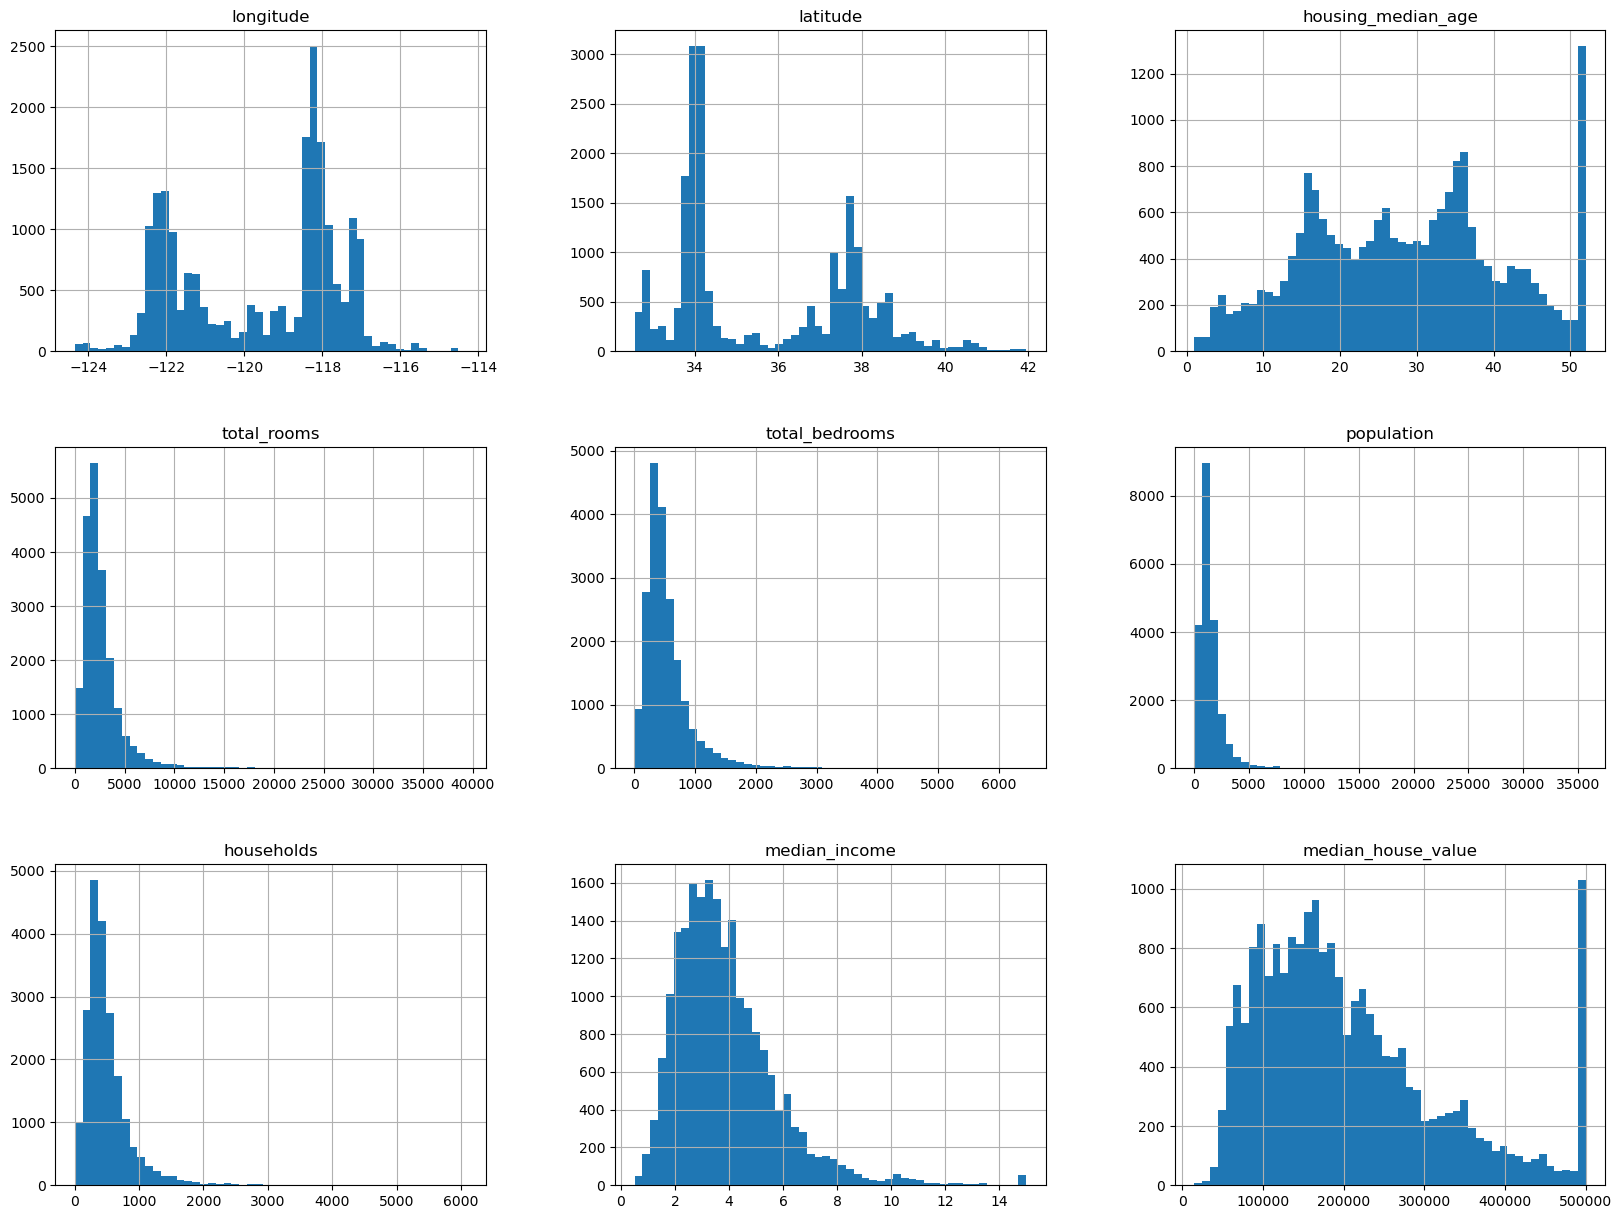

In [9]:
housesDF.hist(bins=50, figsize=(20, 15))
plt.show()

There are a few things to notice here

1. The values follow various distribution(s)
2. They cover a variety of scales
3. Some values (e.g. `median_house_value` and `housing_median_age` have extreme values which probably represent some sort of cut off or binning

## Split the data into training and test sets

It is important to do this early. The risk is that you'll bias your models and end up with bad generalization errors otherwise. Given that we're going to be playing with feature engineering, scaling and other transformations, this might seem premature, but we'll use Pipelines to address that. At this point, it would also be good to start thinking about selecting a performance measure. For a regression like this RMSE is simple and will probably be sufficient, but the documentation has a section on [metrics and scoring](https://scikit-learn.org/stable/modules/model_evaluation.html) which can help you decide more complicated cases.

When splitting the training and test set, we want to make sure that both sets are sampled without bias. In our example, we are to assume that `median_income` will be important to our final housing price predictions and we want to make sure that our training set includes data from the full range of incomes. Since `median_income` is an (almost) continuous variable, the idea is to bin the values into categories, then use those categories to sample from.

<Axes: >

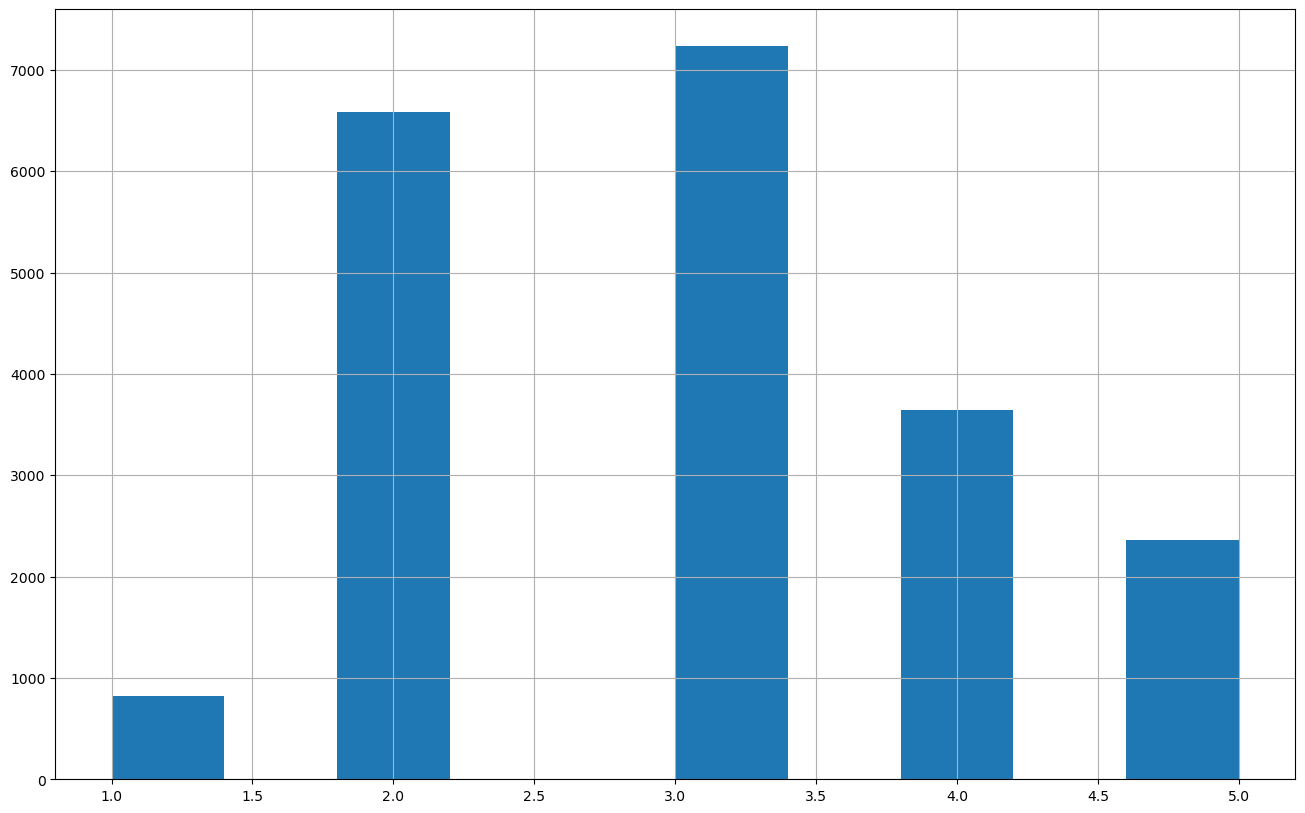

In [10]:
housesDF['income_cat'] = pd.cut(housesDF['median_income'],
       bins = [0, 1.5, 3.0, 4.5, 6.0, np.inf],
       labels = [1, 2, 3, 4, 5]
)
housesDF['income_cat'].hist()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housesDF, housesDF['income_cat']):
    trainDForig = housesDF.loc[train_idx]
    testDF = housesDF.loc[test_idx]

trainDF = trainDForig.copy()

<Axes: >

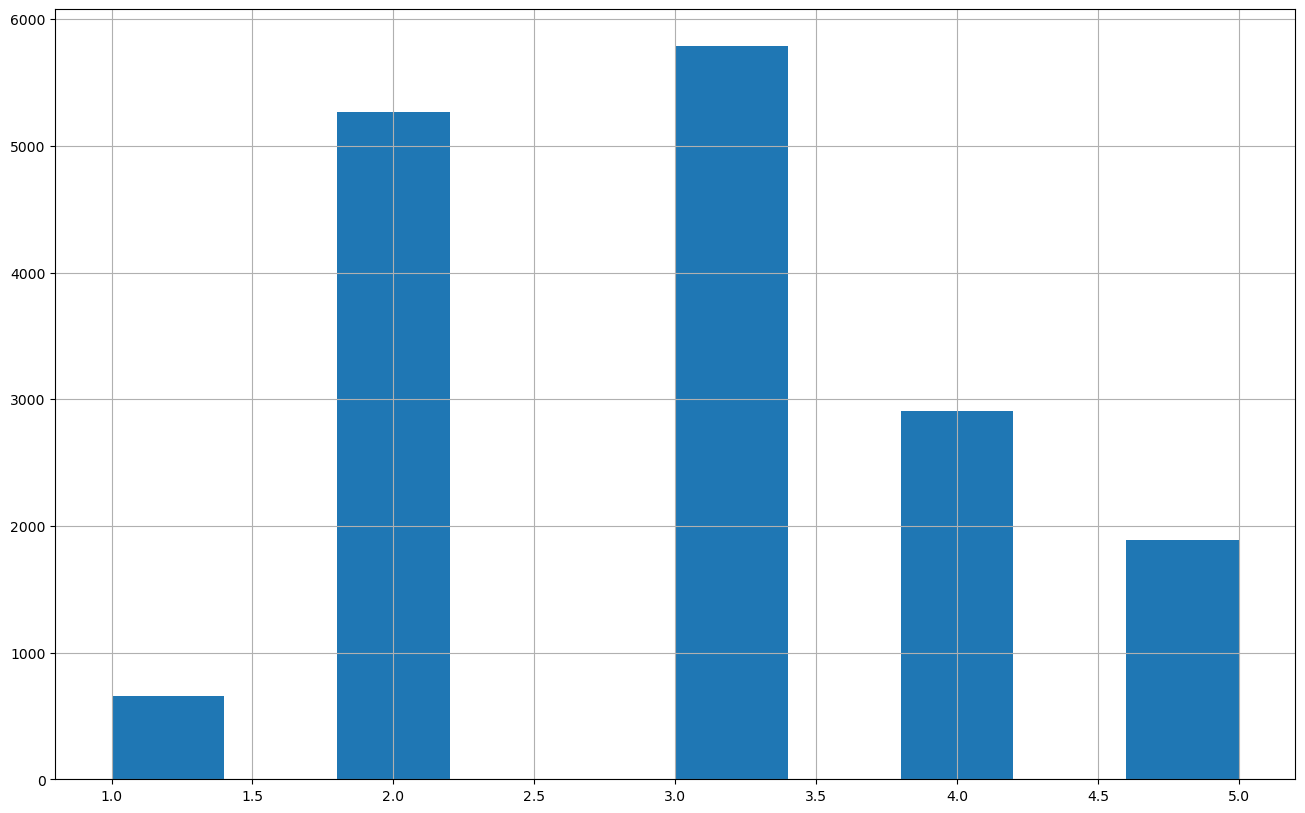

In [12]:
trainDF['income_cat'].hist()

So our training set looks like it samples the various income categories well. We no longer need the `income_cat` column, so we'll drop it from both sets

## 3. Prepare the data, tidy missing values etc.

The histograms for latitude and longitude are probably hiding some structure, all of the values should fall somewhere on a map of California...

In [13]:
trainDF

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,2
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,5
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,2
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,2
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,3
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN,4
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND,2
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN,3
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN,3


<Axes: xlabel='longitude', ylabel='latitude'>

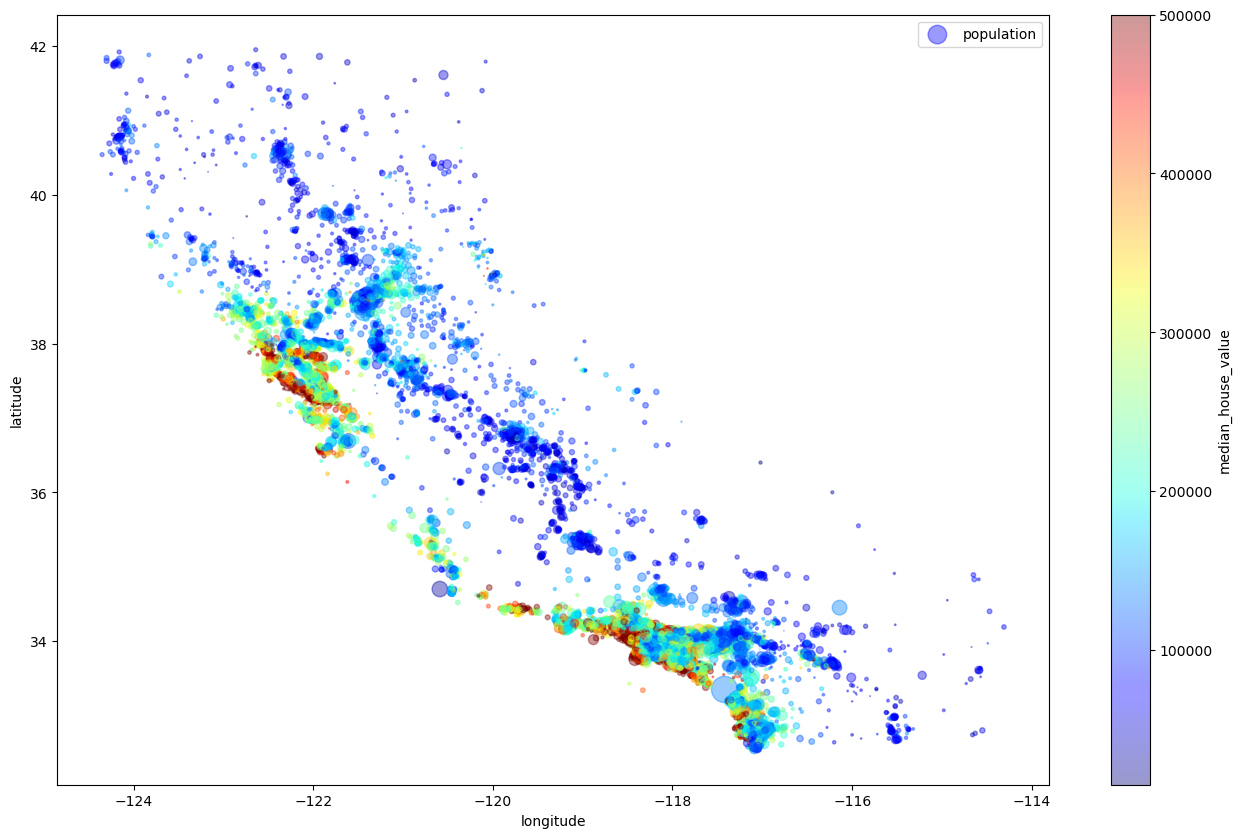

In [14]:
trainDF.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.4,
    s=trainDF['population']/100,
    label='population',
    c='median_house_value',
    cmap=plt.get_cmap("jet"),
    colorbar=True
)

After taking a look at the individual features, the next thing is to look at combinations of features. Often this can help you prepare the dataset so that the algorithms you select have the best chance for success

In [15]:
trainDF.corr(numeric_only=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105823,0.048909,0.076686,0.108071,0.063146,-0.019615,-0.047466
latitude,-0.924478,1.000000,0.005737,-0.039245,-0.072550,-0.115290,-0.077765,-0.075146,-0.142673
housing_median_age,-0.105823,0.005737,1.000000,-0.364535,-0.325101,-0.298737,-0.306473,-0.111315,0.114146
total_rooms,0.048909,-0.039245,-0.364535,1.000000,0.929391,0.855103,0.918396,0.200133,0.135140
total_bedrooms,0.076686,-0.072550,-0.325101,0.929391,1.000000,0.876324,0.980167,-0.009643,0.047781
population,0.108071,-0.115290,-0.298737,0.855103,0.876324,1.000000,0.904639,0.002421,-0.026882
households,0.063146,-0.077765,-0.306473,0.918396,0.980167,0.904639,1.000000,0.010869,0.064590
median_income,-0.019615,-0.075146,-0.111315,0.200133,-0.009643,0.002421,0.010869,1.000000,0.687151
median_house_value,-0.047466,-0.142673,0.114146,0.135140,0.047781,-0.026882,0.064590,0.687151,1.000000


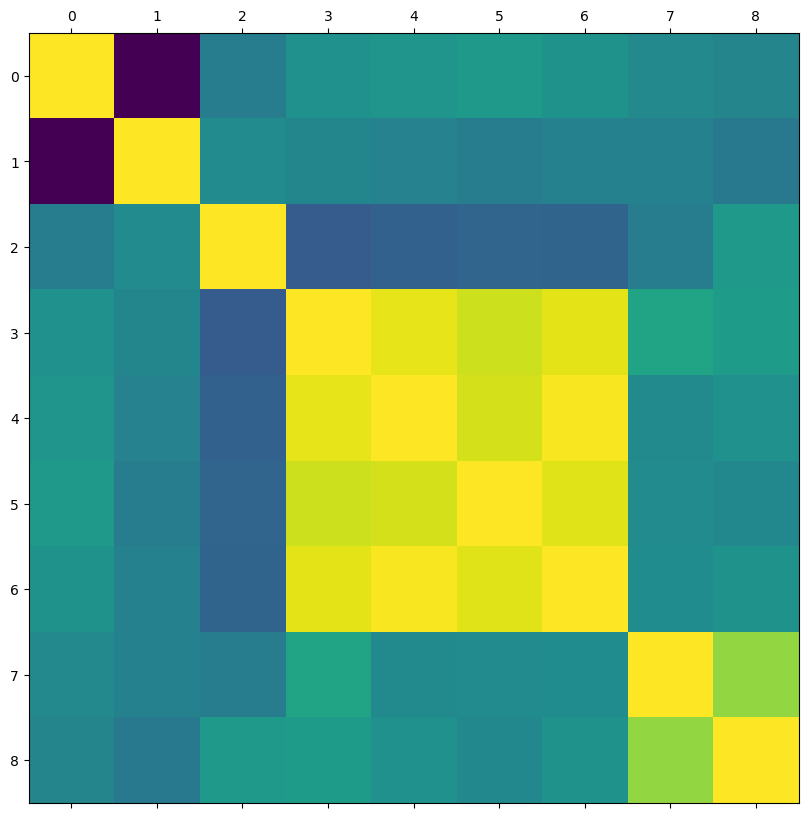

In [16]:
fig, ax = plt.subplots()

ax.matshow(trainDF.corr(numeric_only=True))

To dig a little deeper, you can look at the `scatter_matrix` which plots the numerical values of features against each other 

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

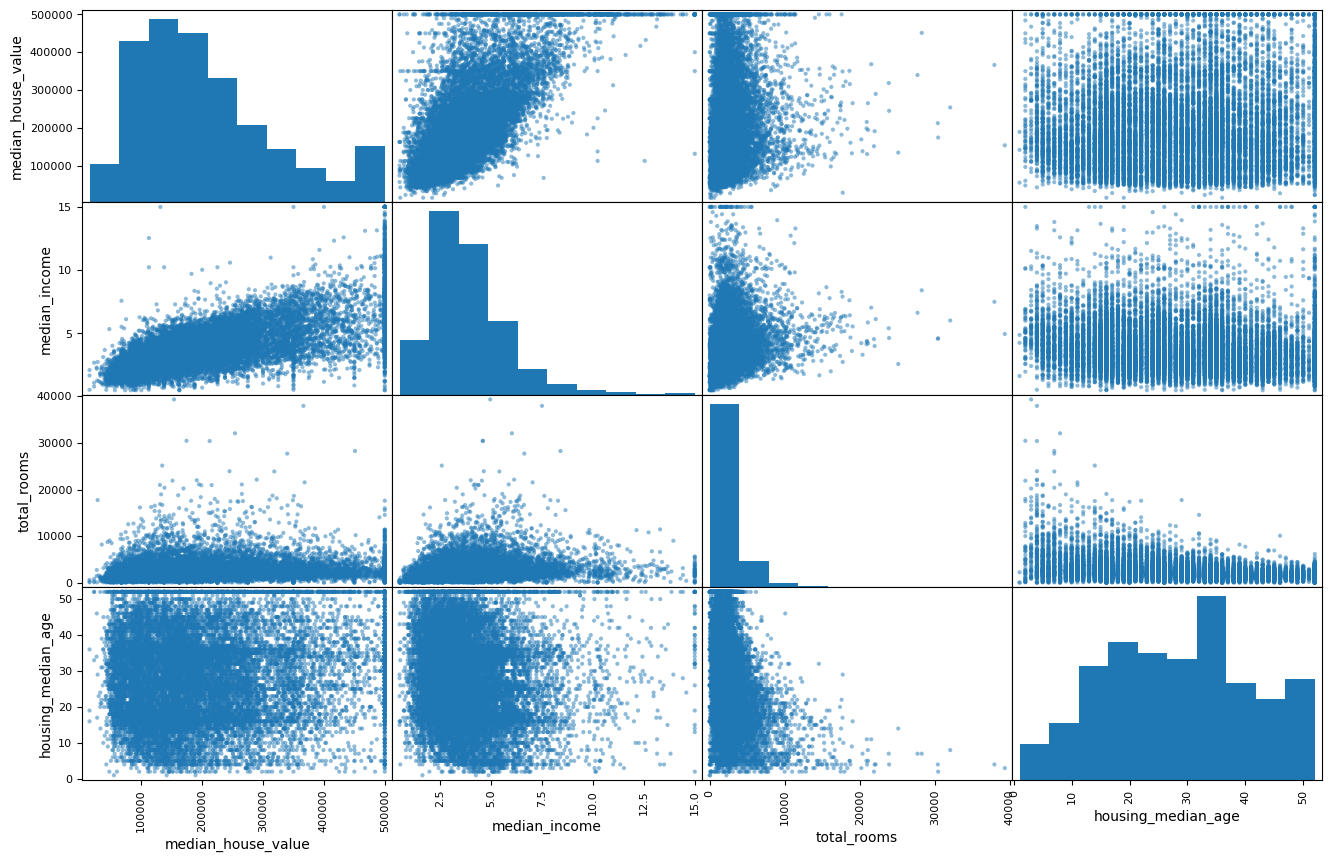

In [17]:
from pandas.plotting import scatter_matrix

attributes = [
    'median_house_value',
    'median_income',
    'total_rooms',
    'housing_median_age'
]
scatter_matrix(trainDF[attributes])

The `median_income` shows strong positive correlation with the `median_house_value` (see the [wikipedia entry for correlation](https://en.wikipedia.org/wiki/Correlation)). You can see horizontal lines showing a hard cap of \\$500,000 as well as fainter lines clustered around some other figures (\\$450,000, \\$350,000) etc. These are likely to be artifacts of the way the data was collected or encoded and you should decide what to do with them. For example, it might be worth trying to train your model without the entries valued at \\$500,000 (assuming that the actual values were larger but were encoded as \\$500,000 during data entry).

In [18]:
trainDF.drop(trainDF[trainDF['median_house_value']>=500000].index, inplace=True)
trainDF.reset_index(inplace=True, drop=True)

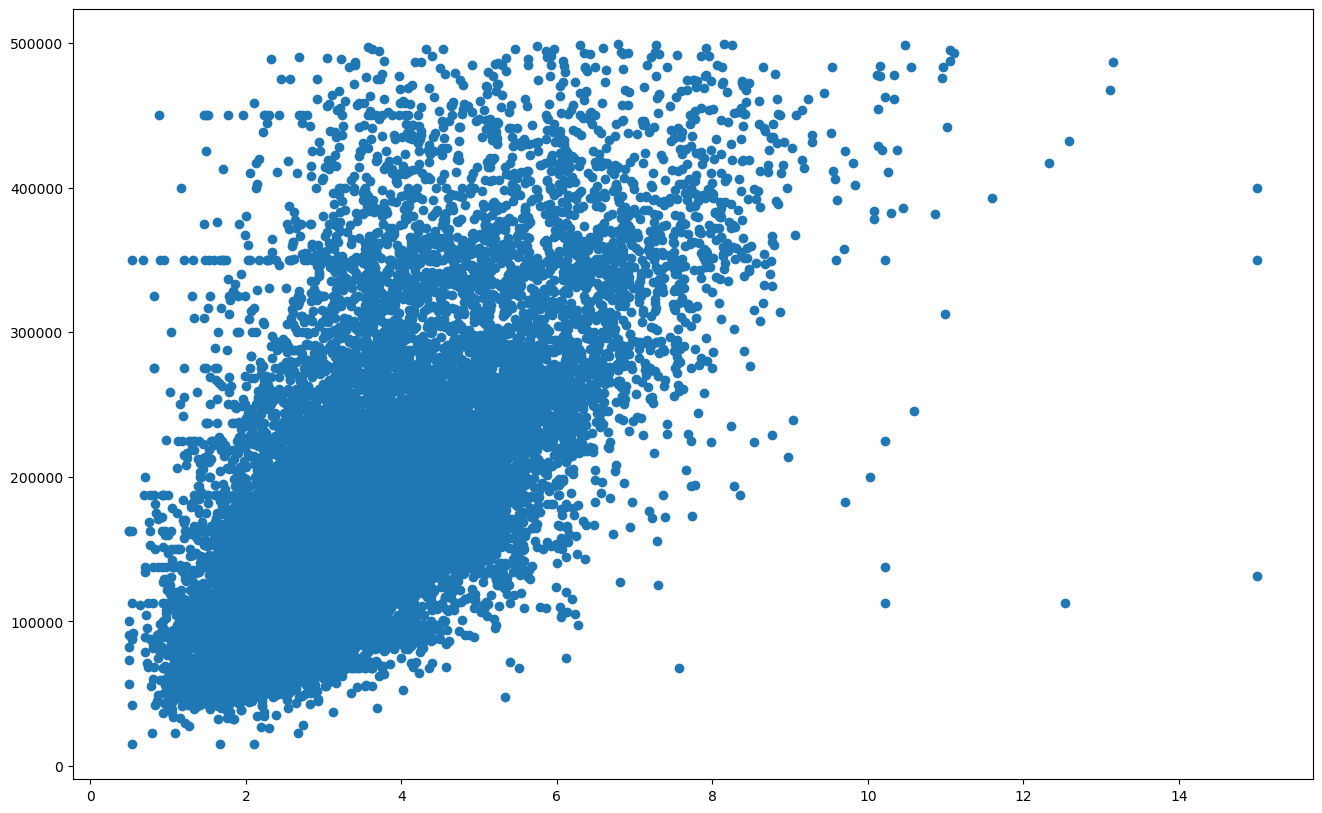

In [19]:
fix, ax = plt.subplots()
ax.scatter(trainDF['median_income'], trainDF['median_house_value'])

It is also useful to look at combinations at attributes. For example, we have the total number of households per district and the total number of bedrooms, but we could combine those to give the number of rooms per household...

In [20]:
trainDF['rooms_per_household'] = trainDF['total_rooms'] / trainDF['households']
trainDF['bedrooms_per_room'] = trainDF['total_bedrooms'] / trainDF['total_rooms']
trainDF['population_per_household'] = trainDF['population'] / trainDF['households']

In [21]:
trainDF.corr(numeric_only=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924059,-0.099815,0.048541,0.076398,0.108714,0.062999,-0.009457,-0.042272,-0.029674,0.098105,-0.000759
latitude,-0.924059,1.000000,0.001156,-0.036287,-0.073051,-0.119477,-0.079072,-0.075997,-0.151721,0.121772,-0.129623,0.005160
housing_median_age,-0.099815,0.001156,1.000000,-0.376351,-0.331560,-0.296999,-0.312413,-0.189657,0.071053,-0.176488,0.158585,0.016879
total_rooms,0.048541,-0.036287,-0.376351,1.000000,0.933402,0.858052,0.921268,0.221026,0.145167,0.138553,-0.192963,-0.024763
total_bedrooms,0.076398,-0.073051,-0.331560,0.933402,1.000000,0.877391,0.979700,0.017006,0.074371,0.012186,0.077629,-0.028264
population,0.108714,-0.119477,-0.296999,0.858052,0.877391,1.000000,0.905899,0.037468,0.012130,-0.072884,0.031046,0.076443
households,0.062999,-0.079072,-0.312413,0.921268,0.979700,0.905899,1.000000,0.040702,0.095630,-0.080230,0.058232,-0.027349
median_income,-0.009457,-0.075997,-0.189657,0.221026,0.017006,0.037468,0.040702,1.000000,0.644897,0.314352,-0.638124,0.030467
median_house_value,-0.042272,-0.151721,0.071053,0.145167,0.074371,0.012130,0.095630,0.644897,1.000000,0.107339,-0.225087,-0.019408
rooms_per_household,-0.029674,0.121772,-0.176488,0.138553,0.012186,-0.072884,-0.080230,0.314352,0.107339,1.000000,-0.410691,-0.005725


To deal with missing values, you can either discard the corresponding data, or replace them with some useful value. Personally, I usually try discarding them first, but if that isn't feasible (throwing away too much valuable data), then scikit-learn has some convenience classes which will help fill in those values.

In [22]:
from sklearn.impute import SimpleImputer

In [23]:
median_imputer = SimpleImputer(strategy='median')

trainDF_num = trainDF.drop('ocean_proximity', axis=1)

median_imputer.fit(trainDF_num)

SimpleImputer(strategy='median')

In [24]:
X = median_imputer.transform(trainDF_num)
type(X)

numpy.ndarray

In [25]:
trfDF_num = pd.DataFrame(
    X,
    columns=trainDF_num.columns, 
    index=trainDF_num.index
)
trfDF_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,2.0,5.485836,0.205784,3.168555
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,5.0,6.927083,0.160714,2.623698
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,2.0,5.393333,0.191595,2.223333
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,2.0,3.886128,0.276505,1.859213
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,3.0,6.096552,0.182692,3.167241


For the categorical values, we will use one hot encoding. You can do this explicitly with `pd.get_dummies`, but similar to what we did with the Imputer, using the corresponding sklearn class lets us reuse the transformation conveniently

In [26]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

trainDF_cat = trainDF[['ocean_proximity']]
X = cat_encoder.fit_transform(trainDF_cat)
type(X)

scipy.sparse._csr.csr_matrix

In [27]:
trfDF_cat = pd.DataFrame(
    X.toarray(),
    columns = cat_encoder.categories_[0],
    index = trainDF_cat.index
)

#### Feature Scaling

Generally, machine learning algorithms want to work with numerical values which share a similar scale. Taking logs etc. can help, but again sklearn also includes some convenience classes, we'll use `StandardScaler` which subtracts the mean and scales to unit variance. At this point, we'll also start building a transformation [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Pipelines are important because your data tidyup and feature engineering is likely to get quite complicated, and your going to need to apply it many, many times while selecting and tuning your models. Packing the transformations up as a pipeline lets us do this reliably 

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [29]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

X = num_pipeline.fit_transform(trainDF_num)

In [30]:
trfDF_num = pd.DataFrame(
    X,
    columns=trainDF_num.columns, 
    index=trainDF_num.index
)

In [31]:
trfDF_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-0.946079,1.330025,0.050732,0.592251,0.632163,0.710523,0.548363,-0.957706,-1.234108,-0.926258,0.047963,-0.159108,0.003714
1,1.165525,-1.192377,-1.710502,1.268786,0.772568,0.513638,0.712460,1.692404,0.903245,2.047983,0.648571,-0.965095,-0.042175
2,0.261978,-0.133247,1.251572,-0.462058,-0.546753,-0.681859,-0.526211,-0.511279,-1.124923,-0.926258,0.009414,-0.412855,-0.075896
3,1.215445,-1.350317,-0.349549,-0.340964,-0.040812,-0.476993,-0.041859,-0.924100,-0.817968,-0.926258,-0.618680,1.105622,-0.106563
4,0.431705,-0.639585,-0.109381,0.434690,0.266627,0.355776,0.214874,0.520709,0.477835,0.065156,0.302465,-0.572056,0.003604


Now we can build a final pipeline

In [32]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

trainDF = trainDForig.copy()
trainDF.drop(trainDF[trainDF['median_house_value']>=500000].index, inplace=True)
trainDF.reset_index(inplace=True, drop=True)

housing_labels = trainDF['median_house_value']
trainDF = trainDF.drop('median_house_value', axis='columns')

rooms_ix      = housesDF.columns.get_loc('total_rooms')
bedrooms_ix   = housesDF.columns.get_loc('total_bedrooms')
population_ix = housesDF.columns.get_loc('population')
households_ix = housesDF.columns.get_loc('households')


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [33]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attr_addr',CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, trainDF.select_dtypes('number').columns),
    ('cat', OneHotEncoder(), trainDF.select_dtypes('object').columns),
])

In [34]:
trainDF = trainDForig.copy()
trainDF.drop(trainDF[trainDF['median_house_value']>=500000].index, inplace=True)
trainDF.reset_index(inplace=True, drop=True)

housing_labels = trainDF['median_house_value']
trainDF = trainDF.drop('median_house_value', axis='columns')

trf = full_pipeline.fit_transform(trainDF)

tDF = pd.DataFrame(
    full_pipeline.fit_transform(trainDF),
    columns = (
        list(trainDF.select_dtypes('number').columns) + 
        [
            'rooms_per_household',
            'population_per_household',
            'bedrooms_per_room'
        ] + 
        list(full_pipeline['cat'].get_feature_names_out())
    ),
    index = trainDF.index
)

In [35]:
tDF.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-0.946079,1.330025,0.050732,0.592251,0.632163,0.710523,0.548363,-0.957706,0.047963,0.003714,-0.152260,0.0,1.0,0.0,0.0,0.0
1,1.165525,-1.192377,-1.710502,1.268786,0.772568,0.513638,0.712460,1.692404,0.648571,-0.042175,-0.848357,0.0,0.0,0.0,0.0,1.0
2,0.261978,-0.133247,1.251572,-0.462058,-0.546753,-0.681859,-0.526211,-0.511279,0.009414,-0.075896,-0.371410,0.0,1.0,0.0,0.0,0.0
3,1.215445,-1.350317,-0.349549,-0.340964,-0.040812,-0.476993,-0.041859,-0.924100,-0.618680,-0.106563,0.940035,0.0,0.0,0.0,0.0,1.0
4,0.431705,-0.639585,-0.109381,0.434690,0.266627,0.355776,0.214874,0.520709,0.302465,0.003604,-0.508906,1.0,0.0,0.0,0.0,0.0


## Training a model

After all of the hard work of preparing the data, the consistent design of scikit-learn lets us actually train a model very quickly...

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [37]:
housing_prepared = trf.copy()

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [39]:
housing_predictions = lin_reg.predict(housing_prepared)
housing_predictions

array([ 88059.2481921 , 297258.00080347, 144097.7815062 , ...,
       213059.17536371, 233128.60112471, 101983.77596306], shape=(15703,))

In [40]:
housing_labels

0         72100.0
1        279600.0
2         82700.0
3        112500.0
4        238300.0
           ...   
15698    268500.0
15699     90400.0
15700    140400.0
15701    258100.0
15702     62700.0
Name: median_house_value, Length: 15703, dtype: float64

In [41]:
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(60003.59319121533)

Not great, not terrible. This is saying our predictions are off by around ~\\$60000 for this model. Ideally though, we want to get an idea of how reliable that figure is before proceeding. One way to do this is to hold out some more of our training data for this evaluation (remember we don't want to touch our actual test data until the very end). We could do this a bunch of times, using different segments of the training data and the look at how the root mean square error varies. That's the basic idea behind sklearn's K-fold cross validation feature. We will do a 10 fold cross validation for our model which will split the training data into 10 folds. The model will be trained 10 times in total using 9 of these folds as the training data and the remaining one to evaluate the model

In [42]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-scores)

In [43]:
print(f"{lin_rmse_scores.mean()} += {lin_rmse_scores.std()}")

60416.87480145489 += 2655.560371112425


At this point we could go back and try to improve the model by adding new features etc. but before we do that we should evaluate some other models to see how they do. Following [Aurélien's analysis](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb), we'll try a RandomForestRegressor model, notice how similar the steps are for the model, this consistent interface is the main benefit of scikit-learn and rewards all of the work put into the data preparation.

In [44]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                         scoring='neg_mean_squared_error', cv=3)
forest_rmse_scores = np.sqrt(-scores)

In [45]:
print(f"{forest_rmse_scores.mean()} += {forest_rmse_scores.std()}")

46181.60109682812 += 625.8239373451719


## Hyperparameters



In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [48]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 6,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 30,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

We can look at the individual cross validation scores

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

58081.50980643676 {'max_features': 2, 'n_estimators': 3}
50251.76573873039 {'max_features': 2, 'n_estimators': 10}
47993.10253504552 {'max_features': 2, 'n_estimators': 30}
54841.42872223407 {'max_features': 4, 'n_estimators': 3}
47554.89251999909 {'max_features': 4, 'n_estimators': 10}
45734.010927225725 {'max_features': 4, 'n_estimators': 30}
52604.83935878622 {'max_features': 6, 'n_estimators': 3}
47111.45051368194 {'max_features': 6, 'n_estimators': 10}
45165.56353995215 {'max_features': 6, 'n_estimators': 30}
53340.01833509266 {'max_features': 8, 'n_estimators': 3}
47177.803626316534 {'max_features': 8, 'n_estimators': 10}
45316.454401087816 {'max_features': 8, 'n_estimators': 30}
57025.315377903906 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
49469.993402049375 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
54211.27761724068 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
48046.65132144317 {'bootstrap': False, 'max_features': 3, 'n_estimators

We have some surprisingly good results with e.g. 4 features and 10 estimators, but our best result is with `max_features=8, n_estimators=30`.

One final thing we can do before we use our model is to look at how the various features fed into these results



In [51]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
#attributes = num_attribs + extra_attribs + cat_one_hot_attribs


sorted(zip(feature_importances, tDF.columns), reverse=True)

[(np.float64(0.29170338580207683), 'median_income'),
 (np.float64(0.15653605244594815), 'ocean_proximity_INLAND'),
 (np.float64(0.10526831555672747), 'population_per_household'),
 (np.float64(0.09026446126175454), 'longitude'),
 (np.float64(0.08167563546120829), 'bedrooms_per_room'),
 (np.float64(0.07813094571002252), 'latitude'),
 (np.float64(0.04298793421127837), 'rooms_per_household'),
 (np.float64(0.040860897767305254), 'housing_median_age'),
 (np.float64(0.023729360443525745), 'ocean_proximity_<1H OCEAN'),
 (np.float64(0.020842900920249388), 'total_rooms'),
 (np.float64(0.01870388358241633), 'total_bedrooms'),
 (np.float64(0.018643582298868436), 'population'),
 (np.float64(0.01859690121171487), 'households'),
 (np.float64(0.006469534379182312), 'ocean_proximity_NEAR OCEAN'),
 (np.float64(0.00546052778581998), 'ocean_proximity_NEAR BAY'),
 (np.float64(0.00012568116190152047), 'ocean_proximity_ISLAND')]

Now we can try out our model on the test data

In [52]:
final_model = grid_search.best_estimator_

X_test = testDF.drop("median_house_value", axis=1)
y_test = testDF["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(f"{final_rmse}")

51079.83863741158


In [53]:
class NumColSelector(BaseEstimator, TransformerMixin):
    '''select all numeric columns of a given dataset'''        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.select_dtypes(include='number')

class CatColSelector(BaseEstimator, TransformerMixin):
    '''select all categorical columns of a given dataset'''        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.select_dtypes(include='object')


In [54]:
trainDF.select_dtypes('number')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15698,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
15699,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
15700,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
15701,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964
